<span style = "color:blue; font-size:24px">DecisionTree</span>

This notebook only focuses on Decision Tree model training.

ZeekData24 Attack Profiles 

Dataset 1: Multiple Attack Types (Credential Access|236706|, Reconnaissance|12762|, Initial Access|2172|, Privilege Escalation|1251|, Persistence|1251|, Defense Evasion|1251|, Exfiltration|50|)

Dataset 2: Multiple Attack Types (Credential Access|45491|, Reconnaissance|3339|, Initial Access|576|, Privilege Escalation|336|, Persistence|336|, Defense Evasion|336|, Exfiltration|30|)

Dataset 3: Multiple Attack Types (Credential Access|150887|, Reconnaissance|10834|, Initial Access|2090|, Privilege Escalation|1193|, Persistence|1193|, Defense Evasion|1193|, Exfiltration|188|)

Dataset 4: Multiple Attack Types (Credential Access|341945|, Reconnaissance|24233|, Initial Access|4602|, Privilege Escalation|2591|, Persistence|2591|, Defense Evasion|2591|, Exfiltration|268|)

Dataset 5: Multiple Attack Types (Credential Access|96159|, Reconnaissance|6927|, Initial Access|1222|, Privilege Escalation|677|, Persistence|677|, Defense Evasion|677|, Exfiltration|23|)

Datest 6: Benign Data

Dataset 7: Benign Data


Zeekdata22 Attack Profiles

Dataset 1: Benign

Dataset 2: Attacks (Reconnaissance|9278720|, Discovery|2086|)

Dataset 3: Attacks (Credential Access|31|, Privilege Escalation|13|, Exfiltration|7|, Lateral Movement|4|, Resource Development|3|, Reconnaissance|2|, Persistence|1|, Initial Access|1|, Defense Evasion|1|)


Script combines all datasets and checks to see what unique attacks are contained in the dataframe and splits the data into attack specific dataframes. Each dataframe contains one attack type and all benign data from the original merged dataframe. Decision tree models are then trained for each attack type using both attack and benign data.

Training and testing combinations are performed for both 2022 and 2024 combined datasets.

This revision only uses Reconnaissance and Credential Access.

25/02/19 19:58:04 WARN Utils: Your hostname, ubuntu-virtual-machine resolves to a loopback address: 127.0.1.1; using 192.168.1.112 instead (on interface ens33)
25/02/19 19:58:04 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/02/19 19:58:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Columns in combined_df_2022:
['ts', 'duration', 'orig_bytes', 'resp_bytes', 'orig_ip_bytes', 'resp_ip_bytes', 'label_tactic']



Training and testing for tactic: Reconnaissance

Train 50% data, Test 50% data

Train 2022 data, Test 2022 data (50-50)



Model for label_tactic: Reconnaissance
Accuracy: 0.9967920820695452
Precision: 0.9967770457561568
Recall: 0.9967920820695452
F1 Score: 0.9967351887732621


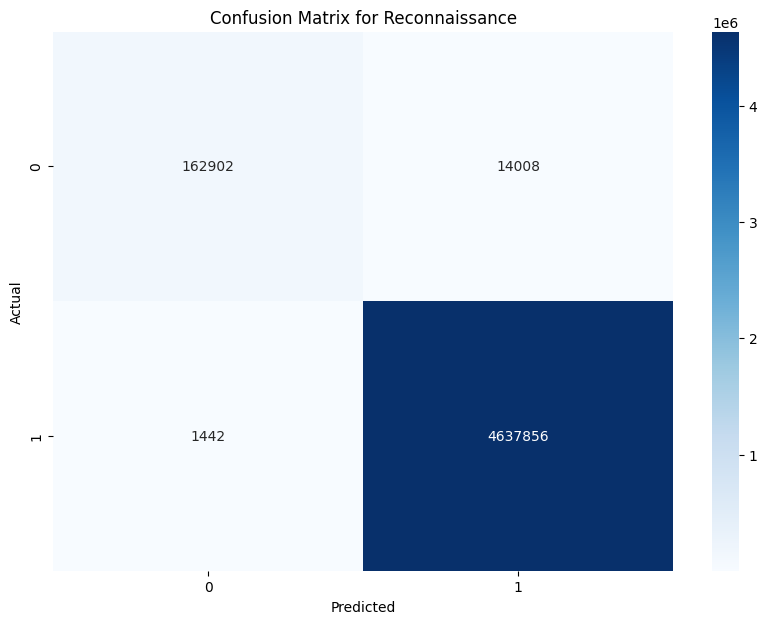


Train 2024 data, Test 2024 data (50-50)



Model for label_tactic: Reconnaissance
Accuracy: 0.9968513953103709
Precision: 0.997002751546735
Recall: 0.9968513953103708
F1 Score: 0.9968888144113024


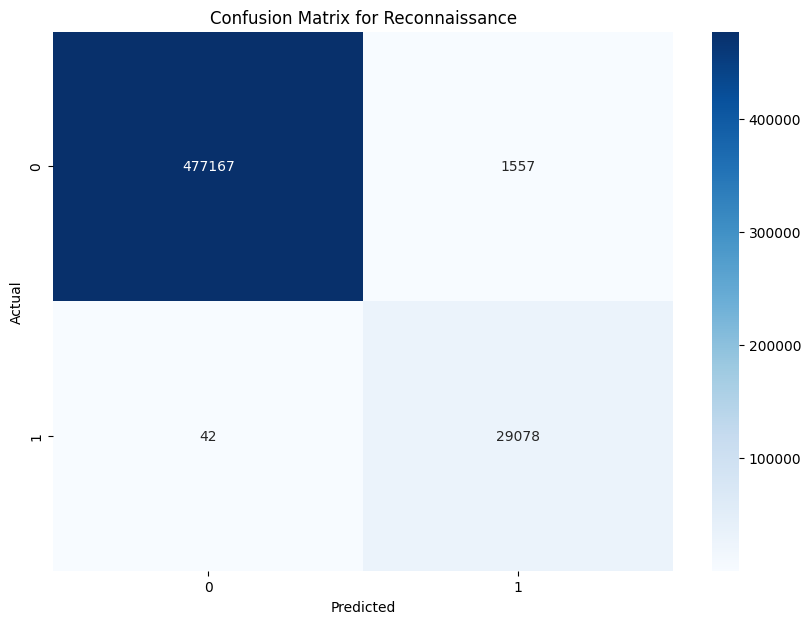


Train 2022 data, Test 2024 data (50-50)



Model for label_tactic: Reconnaissance
Accuracy: 0.5725203015099125
Precision: 0.9494413015558425
Recall: 0.5725203015099125
F1 Score: 0.6783741221878447


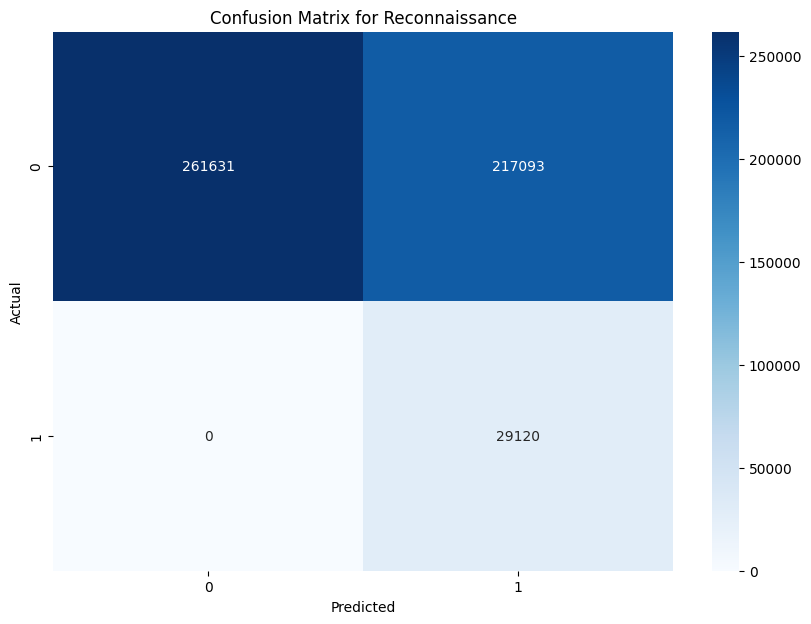


Train 2024 data, Test 2022 data (50-50)


In [ ]:
# Spark imports
import pyspark
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Python imports
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import confusion_matrix
import seaborn as sns
import openpyxl
from openpyxl import Workbook
import os

# Initialize Spark session
spark = SparkSession.builder \
    .appName("Pre-Preprocess Mission Log") \
    .master("spark://192.168.1.2:7077") \
    .config("spark.driver.cores", "2") \
    .config("spark.driver.memory", "10g") \
    .config("spark.executor.memory", "12g") \
    .config("spark.executor.cores", "3") \
    .config("spark.dynamicAllocation.shuffleTracking.enabled", "true") \
    .config("spark.dynamicAllocation.enabled", "true") \
    .config("spark.dynamicAllocation.minExecutors", "5") \
    .config("spark.dynamicAllocation.maxExecutors", "8") \
    .config("spark.executor.instances", "5") \
    .getOrCreate()

# Paths containing 2024 network data
data_paths_2024 = [
    "hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-TestZeekData24/parquet/2024-02-25 - 2024-03-03/part-00000-8b838a85-76eb-4896-a0b6-2fc425e828c2-c000.snappy.parquet",
    "hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-TestZeekData24/parquet/2024-03-03 - 2024-03-10/part-00000-0955ed97-8460-41bd-872a-7375a7f0207e-c000.snappy.parquet",
    "hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-TestZeekData24/parquet/2024-03-10 - 2024-03-17/part-00000-071774ae-97f3-4f31-9700-8bfcdf41305a-c000.snappy.parquet",
    "hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-TestZeekData24/parquet/2024-03-17 - 2024-03-24/part-00000-5f556208-a1fc-40a1-9cc2-a4e24c76aeb3-c000.snappy.parquet",
    "hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-TestZeekData24/parquet/2024-03-24 - 2024-03-31/part-00000-ea3a47a3-0973-4d6b-a3a2-8dd441ee7901-c000.snappy.parquet",
    "hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-TestZeekData24/parquet/2024-10-27 - 2024-11-03/part-00000-69700ccb-c1c1-4763-beb7-cd0f1a61c268-c000.snappy.parquet",
    "hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-TestZeekData24/parquet/2024-11-03 - 2024-11-10/part-00000-f078acc1-ab56-40a6-a6e1-99d780645c57-c000.snappy.parquet"
]

# Paths containing 2022 network data
data_paths_2022 = [
    "hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2022-01-16 - 2022-01-23/part-00000-cbf26680-106d-40e7-8278-60520afdbb0e-c000.snappy.parquet",
    "hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2022-02-06 - 2022-02-13/part-00000-df678a79-4a73-452b-8e72-d624b2732f17-c000.snappy.parquet",
    "hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2022-02-13 - 2022-02-20/part-00000-1da06990-329c-4e38-913a-0f0aa39b388d-c000.snappy.parquet"
]

# Function to load and preprocess data
def load_and_preprocess_data(data_paths):
    df_list = []
    for path in data_paths:
        df = spark.read.parquet(path)
        df = df.select("ts", "duration", "orig_bytes", "resp_bytes", "orig_ip_bytes", "resp_ip_bytes", "label_tactic")
        df = df.fillna({
            "duration": 0,
            "orig_bytes": 0,
            "resp_bytes": 0,
            "orig_ip_bytes": 0,
            "resp_ip_bytes": 0
        })
        df_list.append(df)
    combined_df = df_list[0]
    for df in df_list[1:]:
        combined_df = combined_df.union(df)
    return combined_df

# Load and preprocess 2024 data
combined_df_2024 = load_and_preprocess_data(data_paths_2024)

# Load and preprocess 2022 data
combined_df_2022 = load_and_preprocess_data(data_paths_2022)

# Print the column names of combined_df_20222
print("Columns in combined_df_2022:")
print(combined_df_2022.columns)

# Function to train and evaluate models
def train_and_evaluate(train_df, test_df, tactic, sheet, train_year, test_year, split_ratio):
    from pyspark.ml.feature import VectorAssembler
    from pyspark.ml.classification import DecisionTreeClassifier
    from pyspark.ml.evaluation import MulticlassClassificationEvaluator

    feature_columns = ["duration", "orig_bytes", "resp_bytes", "orig_ip_bytes", "resp_ip_bytes"]
    assembler = VectorAssembler(inputCols=feature_columns, outputCol="features", handleInvalid="skip")
    train_df = assembler.transform(train_df)
    test_df = assembler.transform(test_df)

    train_df = train_df.withColumn("label", F.when(F.col("label_tactic") == tactic, 1).otherwise(0))
    test_df = test_df.withColumn("label", F.when(F.col("label_tactic") == tactic, 1).otherwise(0))

    dt = DecisionTreeClassifier(featuresCol="features", labelCol="label")
    model = dt.fit(train_df)

    predictions = model.transform(test_df)
    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator.evaluate(predictions)

    precision_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
    recall_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
    f1_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

    precision = precision_evaluator.evaluate(predictions)
    recall = recall_evaluator.evaluate(predictions)
    f1_score = f1_evaluator.evaluate(predictions)

    print(f"\nModel for label_tactic: {tactic}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1_score}")

    # Write results to Excel
    sheet.append([tactic, accuracy, precision, recall, f1_score, train_year, test_year, split_ratio])

    # Confusion Matrix
    y_true = predictions.select('label').collect()
    y_pred = predictions.select('prediction').collect()
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {tactic}')
    plt.show()

# Create a workbook and add a worksheet
excel_path = "Model_Results.xlsx"
if os.path.exists(excel_path):
    os.remove(excel_path)
wb = Workbook()
ws = wb.active
ws.title = "Model Results"
ws.append(["Tactic", "Accuracy", "Precision", "Recall", "F1 Score", "Train Year", "Test Year", "Split Ratio"])

# Get distinct values of label_tactic for 2024 data
distinct_label_tactics_2024 = combined_df_2024.select("label_tactic").distinct().collect()
distinct_label_tactics_2024 = [row['label_tactic'] for row in distinct_label_tactics_2024]

# Get distinct values of label_tactic for 2022 data
distinct_label_tactics_2022 = combined_df_2022.select("label_tactic").distinct().collect()
distinct_label_tactics_2022 = [row['label_tactic'] for row in distinct_label_tactics_2022]

# Function to split data into train-test sets
def split_data(df, tactic, train_ratio):
    attack_df = df.filter(F.col("label_tactic") == tactic)
    benign_df = df.filter(F.col("label_tactic") == "none")
    attack_train, attack_test = attack_df.randomSplit([train_ratio, 1 - train_ratio], seed=42)
    benign_train, benign_test = benign_df.randomSplit([train_ratio, 1 - train_ratio], seed=42)
    train_df = attack_train.union(benign_train)
    test_df = attack_test.union(benign_test)
    return train_df, test_df

# Train and evaluate models for each combination
for tactic in distinct_label_tactics_2024:
    #if tactic != "none": # Exclude 'none' tactic
    if tactic in ["Reconnaissance", "Credential Access"]: #Only include reconnaissance and credential access
        print(f"\nTraining and testing for tactic: {tactic}")

        for train_ratio in [0.5, 0.6, 0.7]:
            test_ratio = 1 - train_ratio
            split_ratio = f"{int(train_ratio*100)}-{int(test_ratio*100)}"
            print(f"\nTrain {int(train_ratio*100)}% data, Test {int(test_ratio*100)}% data")

            # Train 2022 data, Test 2022 data
            print(f"\nTrain 2022 data, Test 2022 data ({split_ratio})")
            train_df, test_df = split_data(combined_df_2022, tactic, train_ratio)
            train_and_evaluate(train_df, test_df, tactic, ws, 2022, 2022, split_ratio)

            # Train 2024 data, Test 2024 data
            print(f"\nTrain 2024 data, Test 2024 data ({split_ratio})")
            train_df, test_df = split_data(combined_df_2024, tactic, train_ratio)
            train_and_evaluate(train_df, test_df, tactic, ws, 2024, 2024, split_ratio)

            # Train 2022 data, Test 2024 data
            print(f"\nTrain 2022 data, Test 2024 data ({split_ratio})")
            train_df, _ = split_data(combined_df_2022, tactic, train_ratio)
            _, test_df = split_data(combined_df_2024, tactic, test_ratio)
            train_and_evaluate(train_df, test_df, tactic, ws, 2022, 2024, split_ratio)

            # Train 2024 data, Test 2022 data
            print(f"\nTrain 2024 data, Test 2022 data ({split_ratio})")
            train_df, _ = split_data(combined_df_2024, tactic, train_ratio)
            _, test_df = split_data(combined_df_2022, tactic, test_ratio)
            train_and_evaluate(train_df, test_df, tactic, ws, 2024, 2022, split_ratio)

# Save the workbook
wb.save(excel_path)
